#PERCEPTRON

In [14]:
import numpy as np

class Perceptron(object): # classe perceptron - base para redes neurais 

    def __init__(self, no_of_inputs): # inicialização e atributo de número de entradas (no_of_inputs)
        
        self.weights = np.zeros(no_of_inputs + 1) # inicializa os pesos do perceptron

    def predict(self, inputs): # metodo para realizar as previsões do perceptron com base na entradas 
        
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0] # produto escalar das entradas  e os pesos correspondentes + peso da polarização
        
        if summation > 0: # se soma > 0 
        
          activation = summation # retorno do valor de ativiação é o valor da soma
        
        else:
        
          activation = 0 # retorno do valor de ativação é igual a 0
        
        return activation # retorno do valor da ativiação

#PYTORCH

In [16]:
# importando bibliotecas
import torch
import numpy as np
from torch import nn # base de criação de modelos 

In [18]:
# rede neural simples  - possui única camada linear
class LineNetwork(nn.Module):
  
  def __init__(self):#inicialização da classe base
    
    super().__init__()
    
    self.layers = nn.Sequential( # criar sequência de camadas
    
        nn.Linear(1, 1) # alocar 1 neurônio de entrada e 1 de saída
    
    )

  
  def forward(self,x): # realiza a transformação linear - como a rede computada
   
     return self.layers(x)



In [10]:
 # self.layers = nn.Linear(1,1) - mais simples

### Criando dataset

In [1]:
# importando bilbiotecas - criar conjuntos de dados personalizados e carregar os dados em lotes 
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [12]:
# dataset algébrico - funções algébricas
class AlgebraicDataset(Dataset):

  def __init__(self, f, interval, nsamples): # método de inicialização - atributos (função, intervalo, amostras)

    X = urand.Uniform(interval[0], interval[1]).sample([nsamples]) # lista X de amostras aleatórias
    
    self.data = [(x, f(x)) for x in X] #lista de tuplas

  def __len__(self): # retorna o tamanho do conjunto de dados
    
    return len(self.data)

  def __getitem__(self, idx): # obter elemento a partir do índice idx
    
    return self.data[idx]

In [19]:
line = lambda x: 2*x + 3 # função linear 

interval = (-10, 10) # intervalo da função

train_nsamples = 1000 # quantidade de amostras para dados de treino 

test_nsamples = 100 # quantidade de amostras para dados de teste 

In [26]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples) # criação do dataset para treino

test_dataset = AlgebraicDataset(line, interval, test_nsamples) #criação do dataset para teste

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
# batch_size - número de exemplos processados em cada iteração - todo o conjunto train_nsamples True - exemplos embaralhados aleatoriamente 

test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu" # verificar se a GPU está disponível no sistema - acelerar o treinamento de ml 
print(f"Rodando na {device}")

Rodando na cpu


In [28]:
model = LineNetwork().to(device) # modelo é executado e movido ou na GPU ou CPU

In [29]:
# Função de perda (loss function)
# Erro quadrático médio (Mean Squared Error)
lossfunc = nn.MSELoss()
# Gradiente Descendente Estocástico
# SGD = Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# taxa de aprendizado lr = learning rate

In [30]:
# função para treinar o modelo 
def train(model, dataloader, lossfunc, optimizer):
  
  model.train()
  
  cumloss = 0.0
  
  for X, y in dataloader:
  
    X = X.unsqueeze(1).float().to(device) # adiciona uma dimensão no índice - lidar com tensores com dados unidimensionais - dimensão extra
  
    y = y.unsqueeze(1).float().to(device) # adiciona uma dimensão no índice - lidar com tensores com dados unidimensionais - dimensão extra

    pred = model(X)

    loss = lossfunc(pred, y) # quantifica o quão bem funciona o modelo

    optimizer.zero_grad() # zera os gradientes acumulados
    
    loss.backward() # computa os gradientes
    
    optimizer.step() # anda, de fato, na direção que reduz o erro local

    cumloss += loss.item()     # loss é um tensor; item pra obter o float

  return cumloss / len(dataloader) # a função retorna a média dos erros acumulados / número de lotes 

# função para teste 
def test(model, dataloader, lossfunc):
  
  model.eval() # define o modelo de avaliação 

  cumloss = 0.0 #  é uma variável que acumulará o valor total da função de perda à medida que percorremos os exemplos de teste.
  
  with torch.no_grad(): # desativa cálculos atumotáticos do gradiente 
  
    for X, y in dataloader: # percorrer os exemplos de testes 
  
      X = X.unsqueeze(1).float().to(device) # pré-processamento de dados
  
      y = y.unsqueeze(1).float().to(device) # pré-processamento de dados

      pred = model(X) # usa o modelo para fazer previsões com base na entrada X 

      loss = lossfunc(pred, y) # cálculo do erro - compara as previsões com os valores reais 

      cumloss += loss.item() # acumula o valor da  função de perda para cada lote 

  return cumloss / len(dataloader)# a função retorna a média dos erros acumulados / número de lotes 

### Treinando a rede

In [31]:
# importando biblioteca - gráficos e visualizações 
import matplotlib.pyplot as plt

In [32]:
# Pra visualizar - objetivo visualizar a comparação entre as previsões de um modelo e os dados reais
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  
  ax.spines['left'].set_position('zero') # personalizar as posições das bordas dos gráficos
  
  ax.spines['right'].set_color('none') # personalizar as posições das bordas dos gráficos
  
  ax.spines['bottom'].set_position('zero') # personalizar as posições das bordas dos gráficos
  
  ax.spines['top'].set_color('none') # personalizar as posições das bordas dos gráficos

  samples = np.linspace(interval[0], interval[1], nsamples)
  
  model.eval()
  
  with torch.no_grad():
  
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  
  ax.plot(samples, pred.cpu(), label="model")
  
  plt.legend()
  
  plt.show()

Epoch: 0; Train Loss: 66.57608032226562


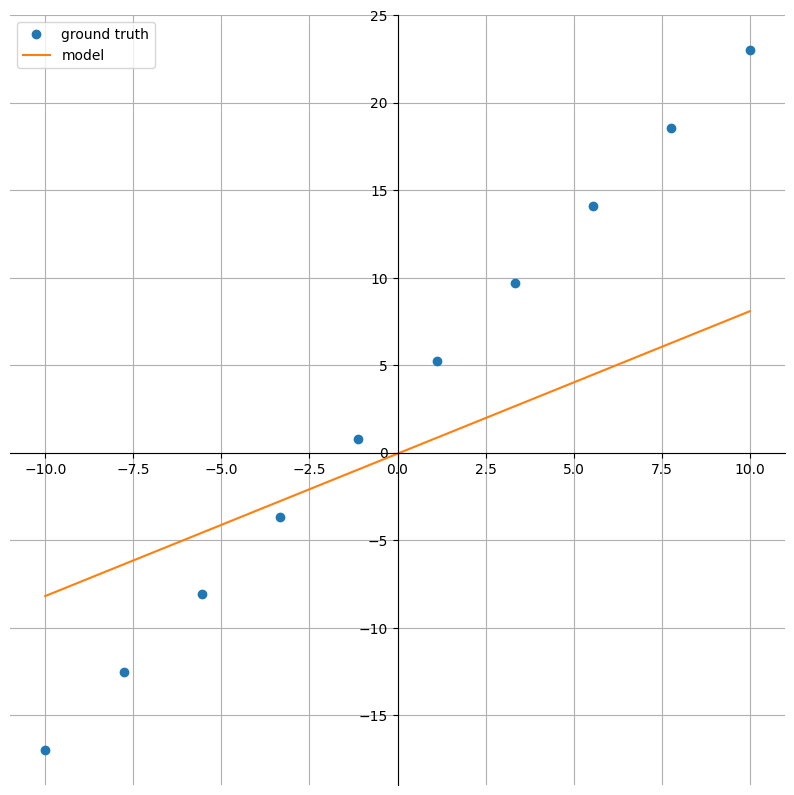

Epoch: 10; Train Loss: 23.145017623901367


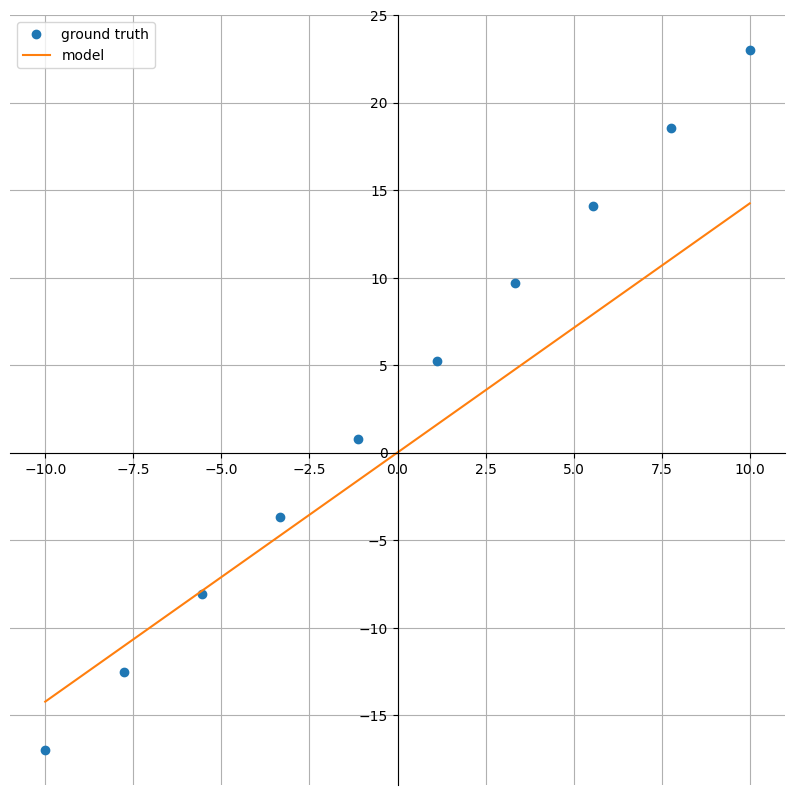

Epoch: 20; Train Loss: 12.133248329162598


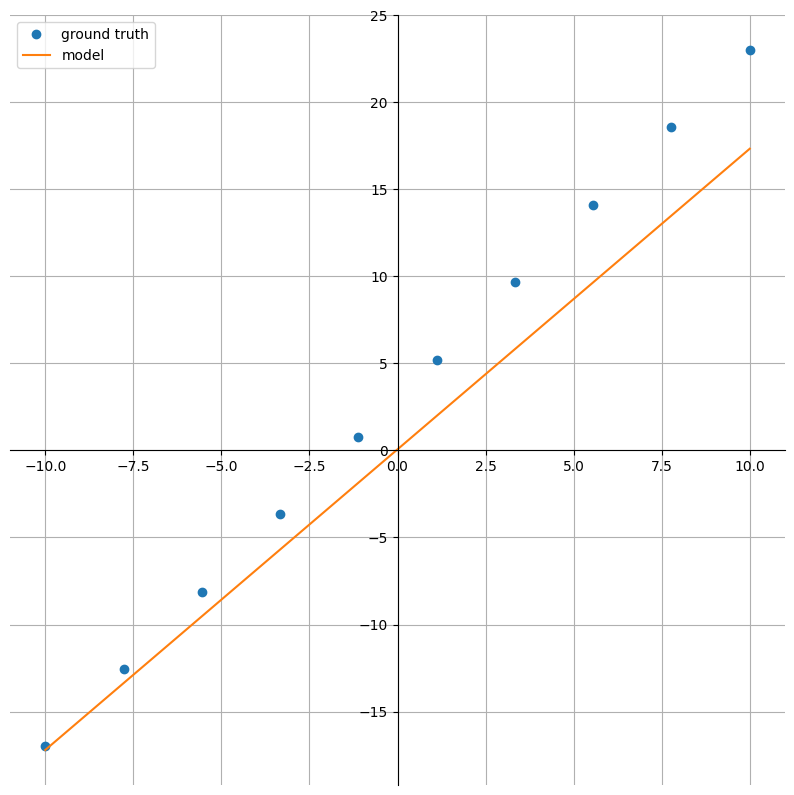

Epoch: 30; Train Loss: 9.156760215759277


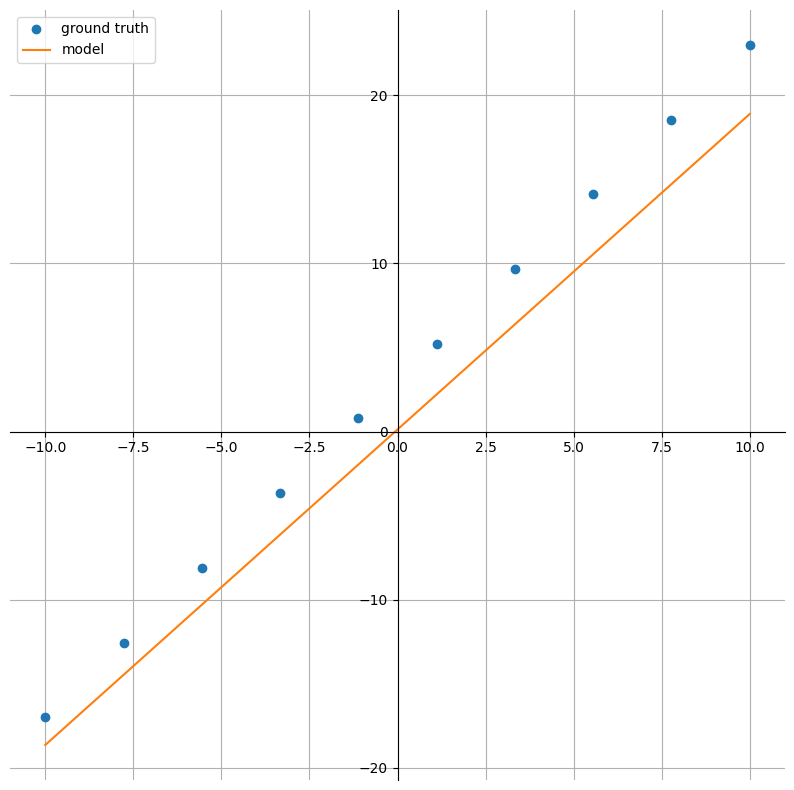

Epoch: 40; Train Loss: 8.179132461547852


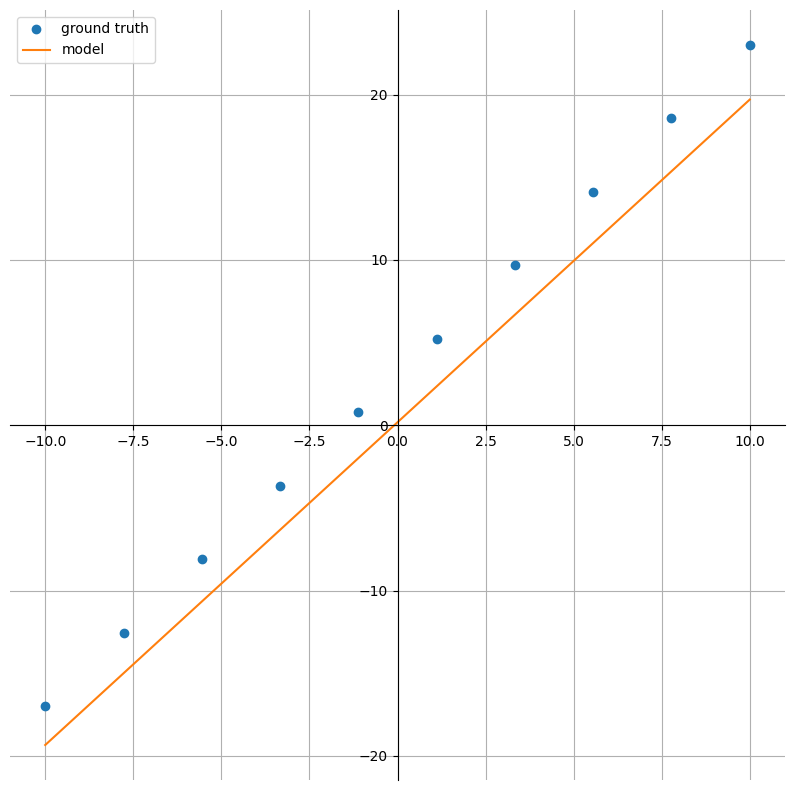

Epoch: 50; Train Loss: 7.705730438232422


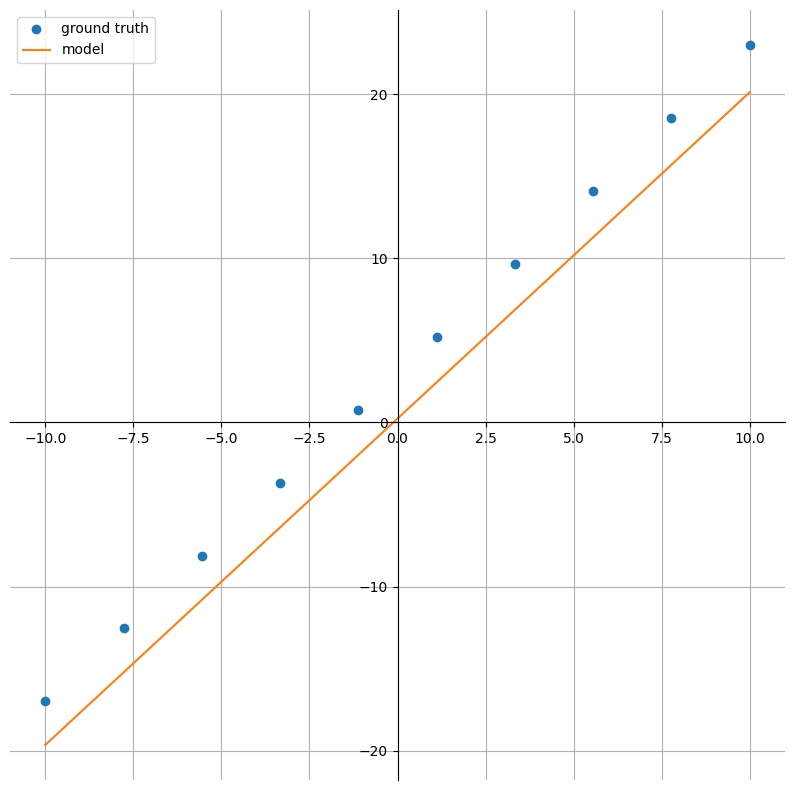

Epoch: 60; Train Loss: 7.366201400756836


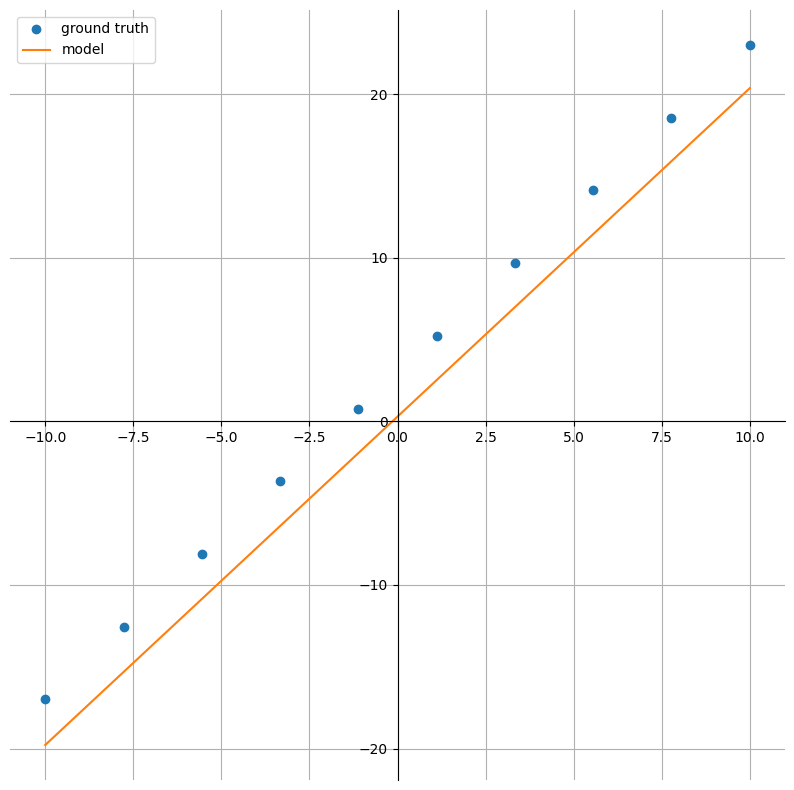

Epoch: 70; Train Loss: 7.068512916564941


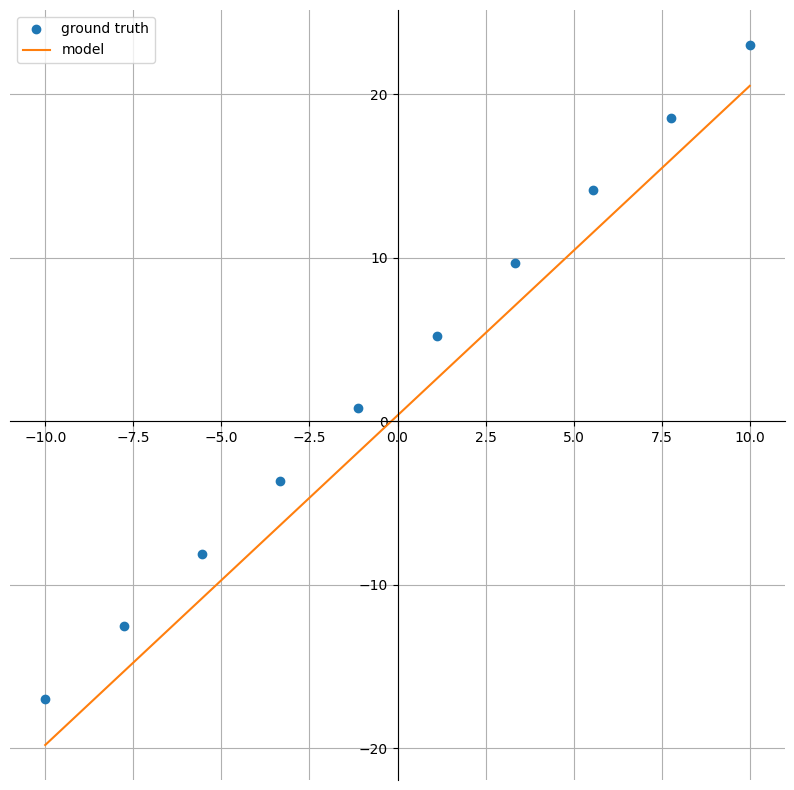

Epoch: 80; Train Loss: 6.789542198181152


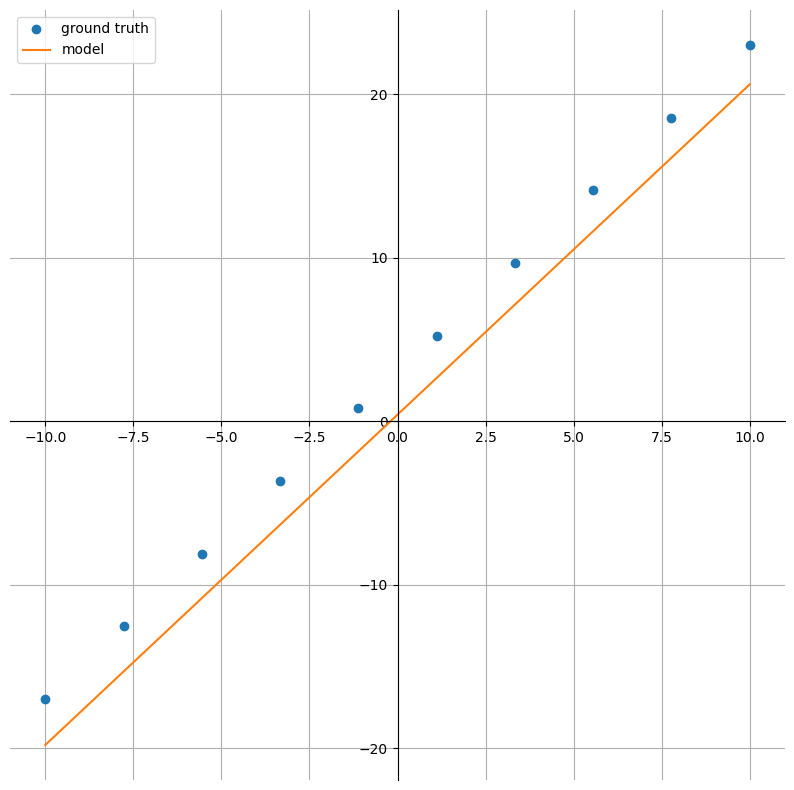

Epoch: 90; Train Loss: 6.5232415199279785


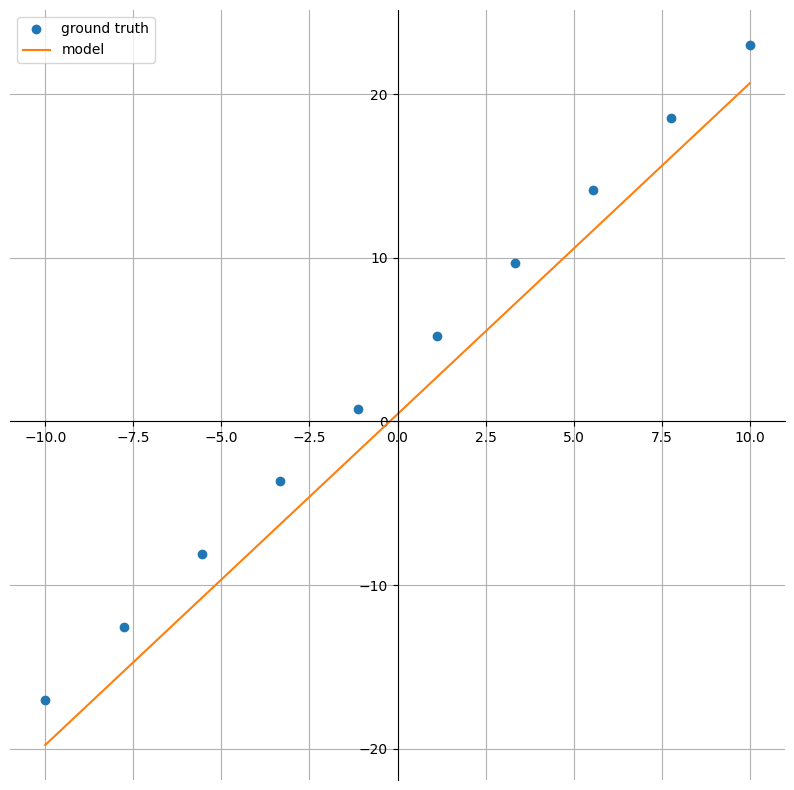

Epoch: 100; Train Loss: 6.267794609069824


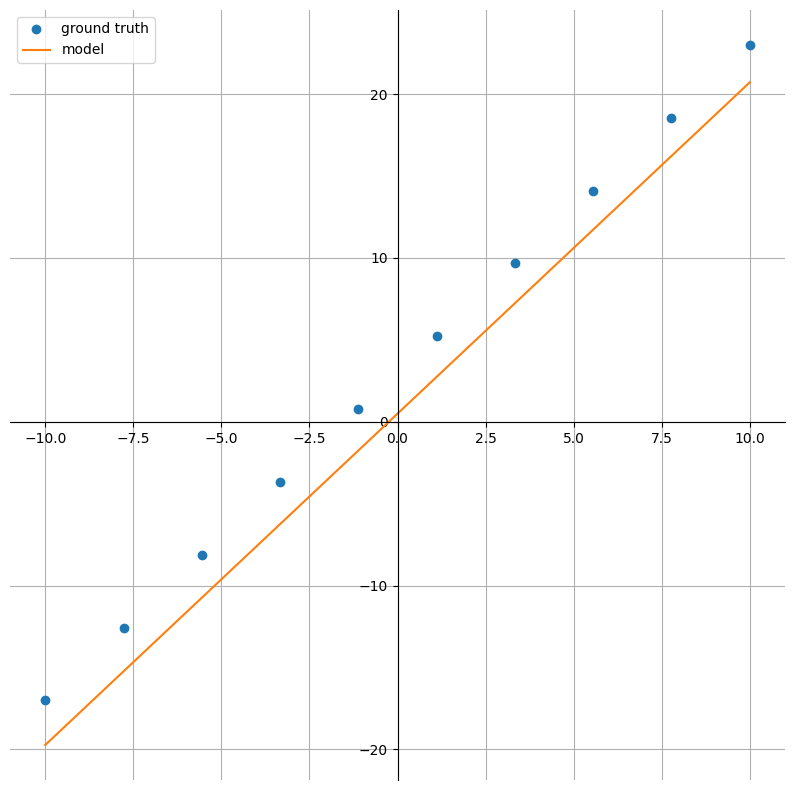

Epoch: 110; Train Loss: 6.022453308105469


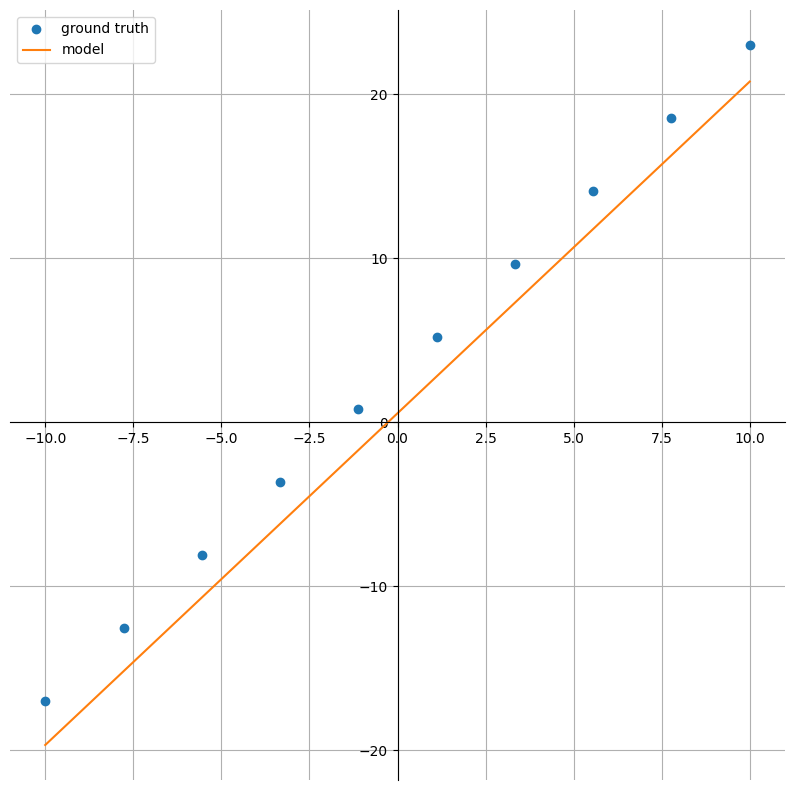

Epoch: 120; Train Loss: 5.786738872528076


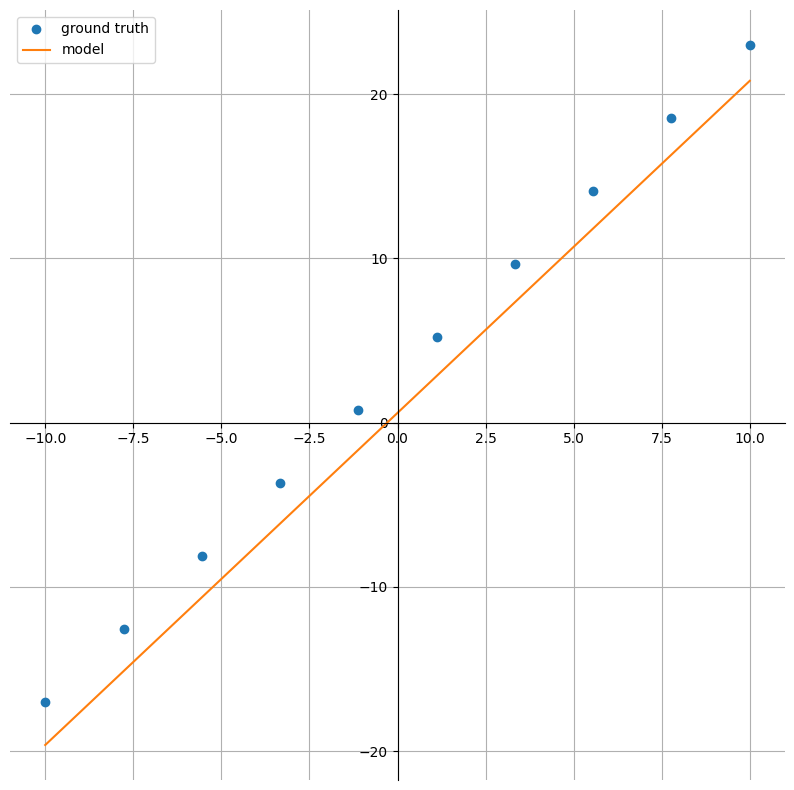

Epoch: 130; Train Loss: 5.560258865356445


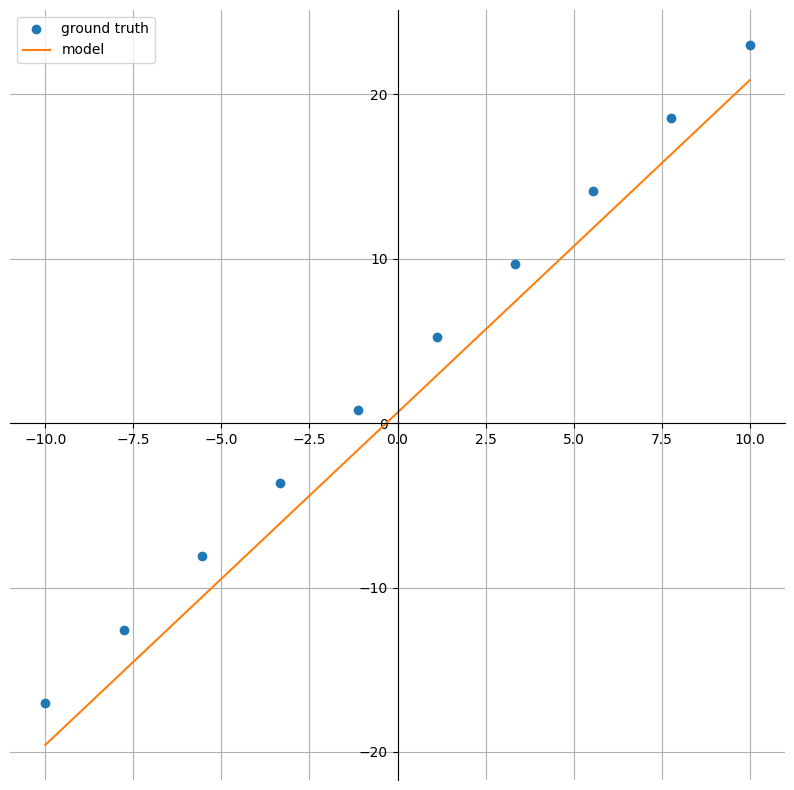

Epoch: 140; Train Loss: 5.342641830444336


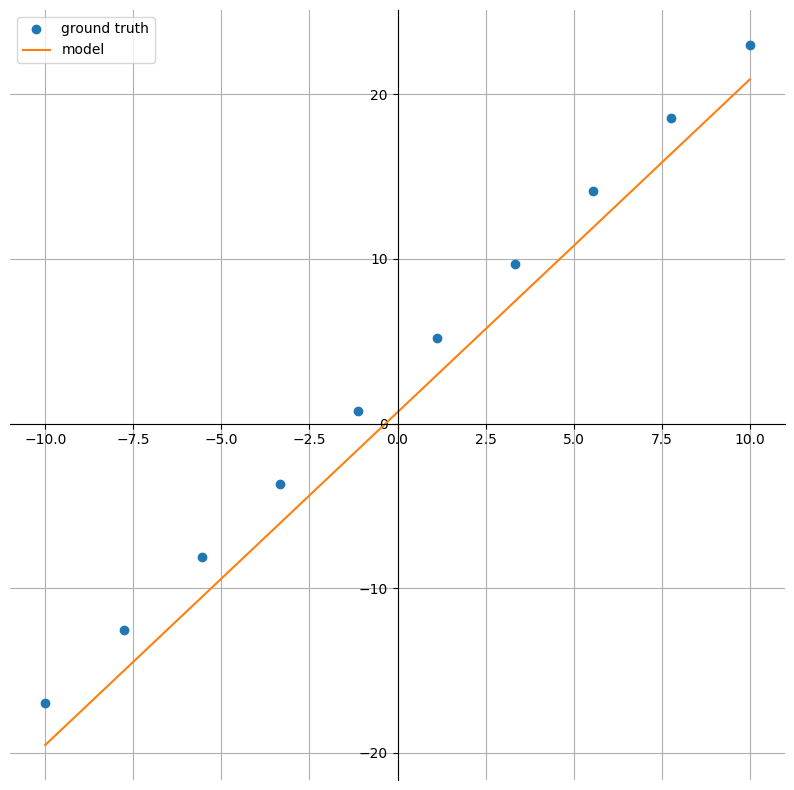

Epoch: 150; Train Loss: 5.133542537689209


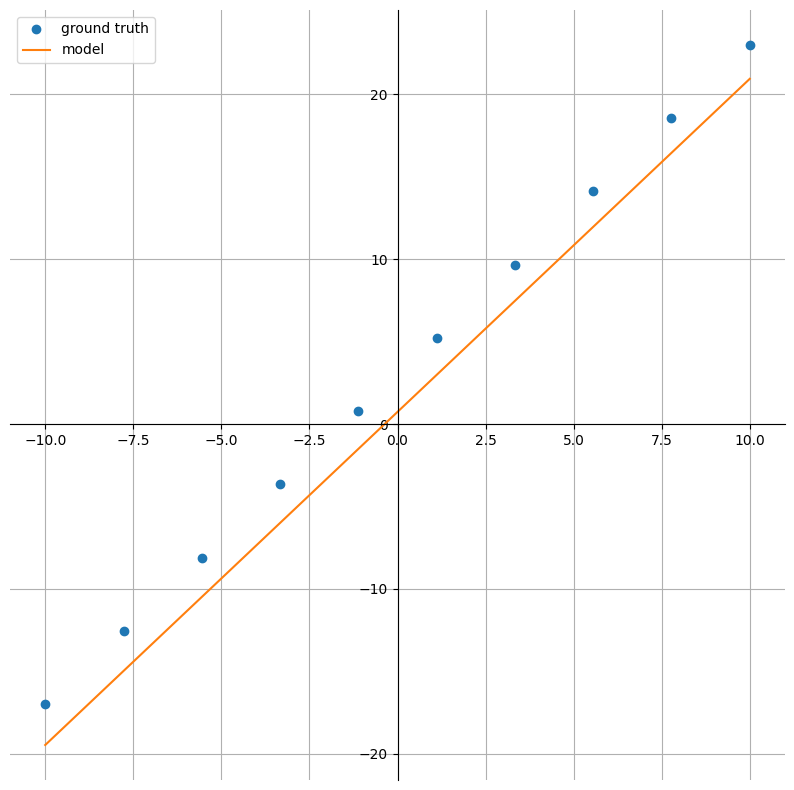

Epoch: 160; Train Loss: 4.932628631591797


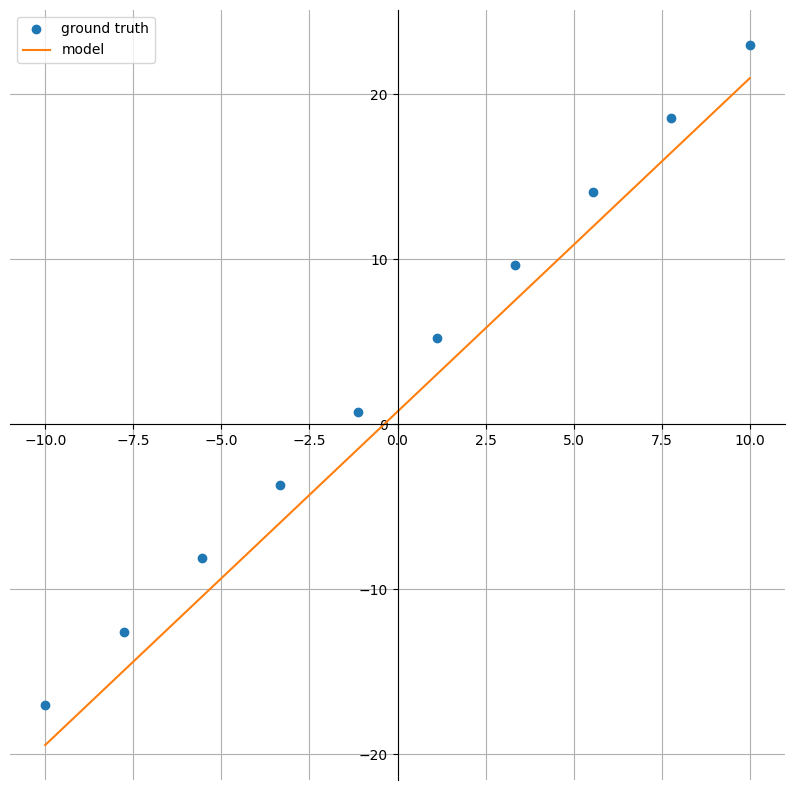

Epoch: 170; Train Loss: 4.7395782470703125


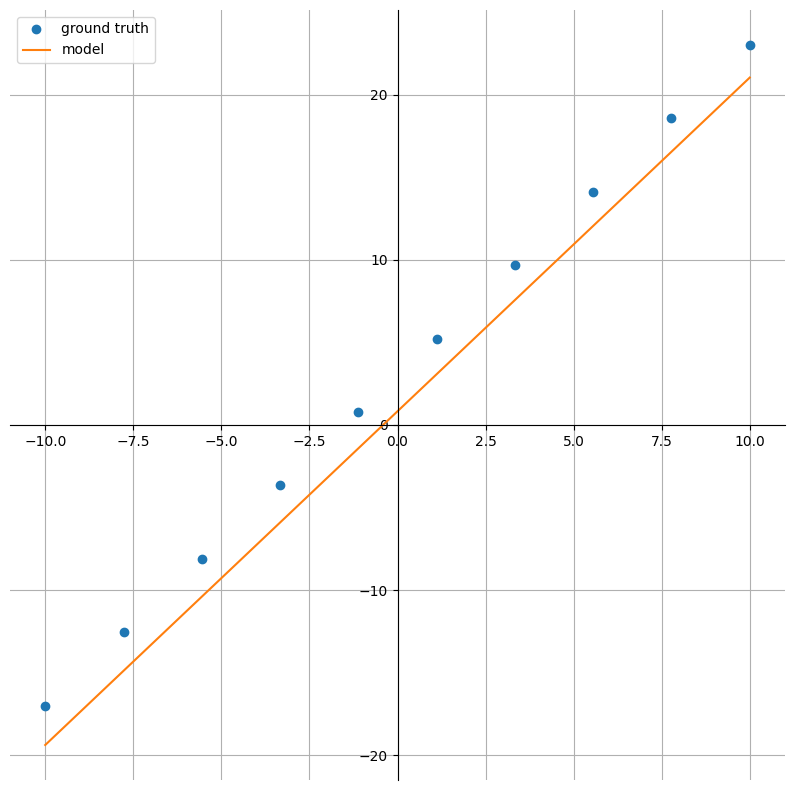

Epoch: 180; Train Loss: 4.554081916809082


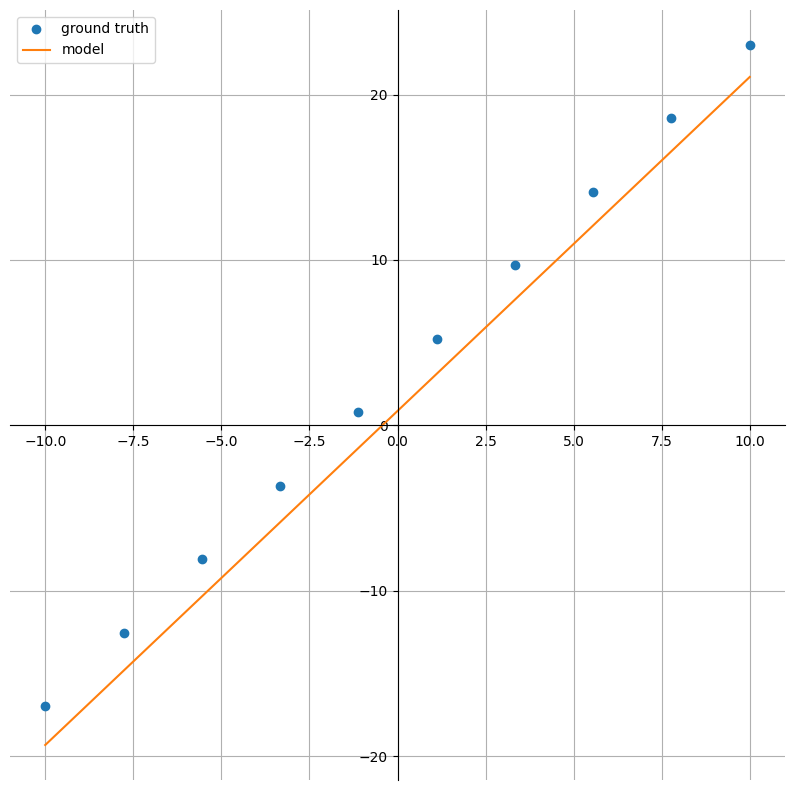

Epoch: 190; Train Loss: 4.3758463859558105


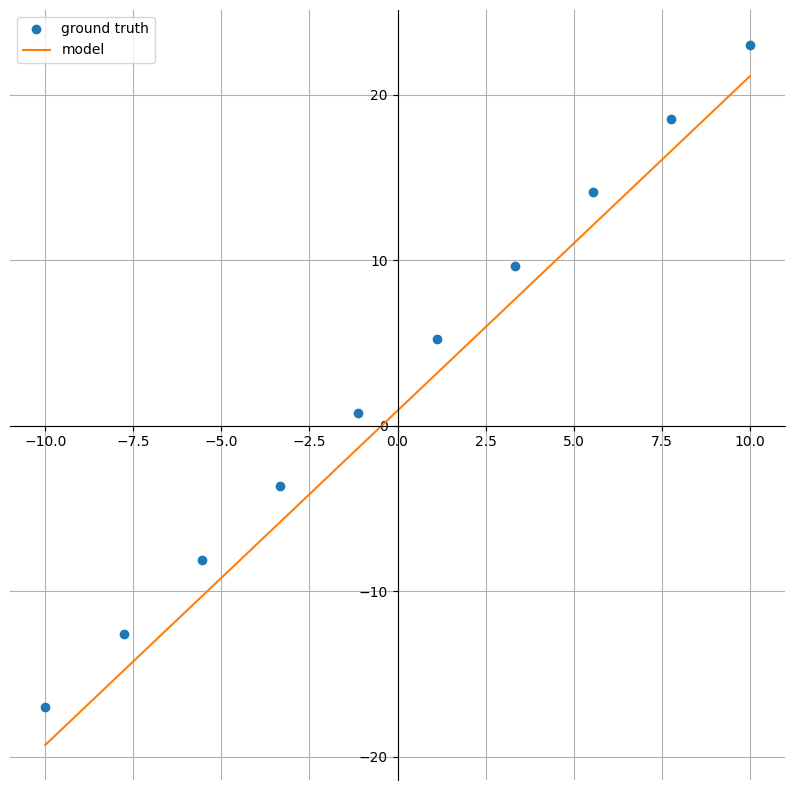

Epoch: 200; Train Loss: 4.204585075378418


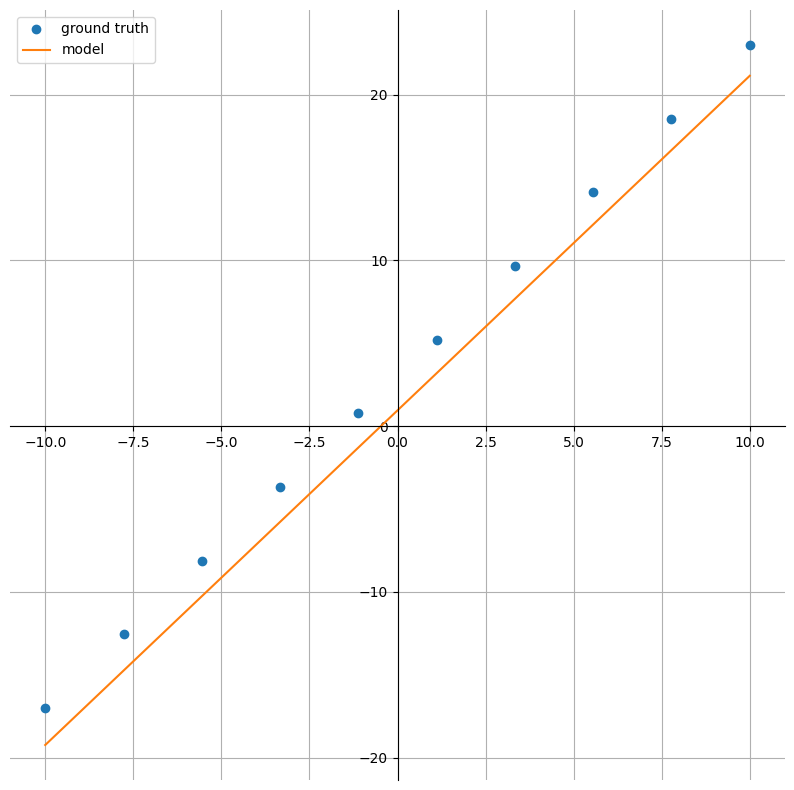

Test Loss: 4.24295711517334


In [33]:
epochs = 201
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(line, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")